In [93]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import simpy
import simpy.events as evt
from scipy.optimize import linprog

This block generates time needed for reaching the desired destination with maximum velocity at a given accelration speed.

In [97]:
def timeTo(a, maxV, d):
    # a       constant acceleration, m/s²
    # maxV    maximumum velocity, m/s
    # d       distance, km
    # return  time in seconds required to travel
    # 
    ta = maxV/a         # time to accelerate to maxV
    da = a*ta**2        # distance traveled during acceleration from 0 to maxV and back to 0
    if (d < da):        # train never reaches full speed?
        return np.sqrt(4.0*d/a)     # time needed to accelerate to half-way point then decelerate to destination
    else:
        return 2*ta + (d-da)/maxV 

This block Creates a dataframe based on number of blocks selected 

In [98]:
def data(N):
    data = pd.DataFrame()
    for i in range(N): 
                data.at[i, 'Start_Point'] = 'S' + str(i+1)
                data.at[i, 'End_Point'] = 'S' + str(i+2)
    
    return data

It manipulates the created data frame by calcuating and  adding the new columns like Distance, Actual_Travle_Time, Dwell time

In [99]:
def structure_data(k):
    
    dt = data(k - 1)
            
    
    #Distance is splitted according to the number of blocks
    total_distance = 145000
    distance_split = total_distance / (k - 1)
    
    dt['Distance'] = distance_split
    dt['Actual_Travel_Time'] = ''
    dt['Dwell Time'] = np.random.normal(3.35,0.9, size= k - 1)     
    return dt

This block manipluates the created dataframe by changing the datatype of two column from text to int and replace the values of two columns with respective station names.

In [124]:
k = 18
dt = structure_data(k)
dt['Distance']=dt['Distance'].apply(lambda x: int(x))
dt['Dwell Time']=dt['Dwell Time'].apply(lambda x: int(x))
dt['Start_Point'] = dt['Start_Point'].replace(['S1'],'London Old Oak Common')
dt['End_Point'] = dt['End_Point'].replace(['S'+str(k)],'Birmingham Interchange')

Calulating the values of Drive time which is time required to reach the destination with maximum velocity

In [153]:
dt['Drive Time'] = timeTo(0.76, 86.1, 145000)/(k-1)
#for i in range(len(dt)):
    #dist = dt.at[i, 'Distance']
   # dt.at[i, 'Drive Time']=int(timeTo(0.76, 86.1, dist))

Creating new column by calculating from Dwell time and Drive  Time 

In [154]:
dt['Actual_Travel_Time'] = dt['Dwell Time'] + dt['Drive Time']
dt['Serial_Number'] = dt.index
dt

,Start_Point,End_Point,Distance,Actual_Travel_Time,Dwell Time,Drive Time,Serial_Number
0,London Old Oak Common,S2,8529,107.728103,2,105.728103,0
1,S2,S3,8529,108.728103,3,105.728103,1
2,S3,S4,8529,107.728103,2,105.728103,2
3,S4,S5,8529,106.728103,1,105.728103,3
4,S5,S6,8529,108.728103,3,105.728103,4
5,S6,S7,8529,108.728103,3,105.728103,5
6,S7,S8,8529,106.728103,1,105.728103,6
7,S8,S9,8529,108.728103,3,105.728103,7
8,S9,S10,8529,107.728103,2,105.728103,8
9,S10,S11,8529,108.728103,3,105.728103,9


Deciding startpoint, Endpoint,by cosindering the delay Actual Travel time and Delay time  

In [188]:
class Train(object):
        def __init__(self, i, dt, maxP = 600):
            self.name = ' [Train '+f"{i:2d}"+']'
            self.dt = dt
            self.maxP = maxP
            self.p = 0
     
     
        def process(self):
            for number in self.dt['Serial_Number']:
                count = 0
                data = self.dt[self.dt['Serial_Number'] == number]
                Start_Point = data['Start_Point'].tolist()
                End_Point = data['End_Point'].tolist()
                Start_Point = Start_Point[0]
                End_Point = End_Point[0]
                #print(End_Location)
                for loc in data['Start_Point']:
                    data1=dt[dt['Start_Point'] == loc]
                    streamtime=data1.iloc[0].at['Actual_Travel_Time']
                    dwelltime=data1.iloc[0].at['Dwell Time']
                    #yield env.timeout(dwelltime)
                    #print(Start_Location)
                    print(f"{now():s} {self.name:s} dep from {Start_Point:s} for {End_Point:s}")
                    yield env.timeout(streamtime)
                    print(f"{now():s} {self.name:s} arr {End_Point:s}")

This is will give start time, end time, time between two trains from starting point by considering the delay in 9 am train

In [191]:
def line1(start=6*3600, stop=10*3600, timing=300):
        yield env.timeout(start-env.now)
        for i in range(int((stop-start)/timing)):
            if ((32400 - start)/timing) == i:
                yield env.timeout(1800)
            p = Train(i, dt)
            env.process(p.process())
            yield env.timeout(timing)
         
         
         
def daytime(p):
    p=int(p)
    return f"{p//3600:02d}:{(p%3600)//60:02d}:{p%60:02d}"
def now():
    return daytime(env.now)

This is will give start time, end time, time between two trains from starting point without considering the delay in 9 am train

In [192]:
def line(start=6*3600, stop=10*3600, timing=300):
        yield env.timeout(start-env.now)
        for i in range(int((stop-start)/timing)):
            #if i==35:
             #   yield env.timeout(1800)
            p = Train(i, dt)
            env.process(p.process())
            yield env.timeout(timing)
         
         
         
def daytime(p):
    p=int(p)
    return f"{p//3600:02d}:{(p%3600)//60:02d}:{p%60:02d}"
def now():
    return daytime(env.now)

This gives the simulation of 48  trains running between 8 blocks with maximum safe velocity and no delay, first train starting at 06:00:00 am and last train reaching destination at 10:25:45 am

In [193]:
env = simpy.Environment()   
env.process(line())
env.run()

06:00:00  [Train  0] dep from London Old Oak Common for S2
06:01:47  [Train  0] arr S2
06:01:47  [Train  0] dep from S2 for S3
06:03:36  [Train  0] arr S3
06:03:36  [Train  0] dep from S3 for S4
06:05:00  [Train  1] dep from London Old Oak Common for S2
06:05:24  [Train  0] arr S4
06:05:24  [Train  0] dep from S4 for S5
06:06:47  [Train  1] arr S2
06:06:47  [Train  1] dep from S2 for S3
06:07:10  [Train  0] arr S5
06:07:10  [Train  0] dep from S5 for S6
06:08:36  [Train  1] arr S3
06:08:36  [Train  1] dep from S3 for S4
06:08:59  [Train  0] arr S6
06:08:59  [Train  0] dep from S6 for S7
06:10:00  [Train  2] dep from London Old Oak Common for S2
06:10:24  [Train  1] arr S4
06:10:24  [Train  1] dep from S4 for S5
06:10:48  [Train  0] arr S7
06:10:48  [Train  0] dep from S7 for S8
06:11:47  [Train  2] arr S2
06:11:47  [Train  2] dep from S2 for S3
06:12:10  [Train  1] arr S5
06:12:10  [Train  1] dep from S5 for S6
06:12:35  [Train  0] arr S8
06:12:35  [Train  0] dep from S8 for S9
06:13:3

06:51:11  [Train  7] dep from S10 for S11
06:51:38  [Train  6] arr S13
06:51:38  [Train  6] dep from S13 for S14
06:51:47  [Train 10] arr S2
06:51:47  [Train 10] dep from S2 for S3
06:52:05  [Train  5] arr S16
06:52:05  [Train  5] dep from S16 for S17
06:52:10  [Train  9] arr S5
06:52:10  [Train  9] dep from S5 for S6
06:52:35  [Train  8] arr S8
06:52:35  [Train  8] dep from S8 for S9
06:53:00  [Train  7] arr S11
06:53:00  [Train  7] dep from S11 for S12
06:53:27  [Train  6] arr S14
06:53:27  [Train  6] dep from S14 for S15
06:53:36  [Train 10] arr S3
06:53:36  [Train 10] dep from S3 for S4
06:53:55  [Train  5] arr S17
06:53:55  [Train  5] dep from S17 for Birmingham Interchange
06:53:59  [Train  9] arr S6
06:53:59  [Train  9] dep from S6 for S7
06:54:23  [Train  8] arr S9
06:54:23  [Train  8] dep from S9 for S10
06:54:49  [Train  7] arr S12
06:54:49  [Train  7] dep from S12 for S13
06:55:00  [Train 11] dep from London Old Oak Common for S2
06:55:16  [Train  6] arr S15
06:55:16  [Train

07:33:55  [Train 13] arr S17
07:33:55  [Train 13] dep from S17 for Birmingham Interchange
07:33:59  [Train 17] arr S6
07:33:59  [Train 17] dep from S6 for S7
07:34:23  [Train 16] arr S9
07:34:23  [Train 16] dep from S9 for S10
07:34:49  [Train 15] arr S12
07:34:49  [Train 15] dep from S12 for S13
07:35:00  [Train 19] dep from London Old Oak Common for S2
07:35:16  [Train 14] arr S15
07:35:16  [Train 14] dep from S15 for S16
07:35:24  [Train 18] arr S4
07:35:24  [Train 18] dep from S4 for S5
07:35:45  [Train 13] arr Birmingham Interchange
07:35:48  [Train 17] arr S7
07:35:48  [Train 17] dep from S7 for S8
07:36:11  [Train 16] arr S10
07:36:11  [Train 16] dep from S10 for S11
07:36:38  [Train 15] arr S13
07:36:38  [Train 15] dep from S13 for S14
07:36:47  [Train 19] arr S2
07:36:47  [Train 19] dep from S2 for S3
07:37:05  [Train 14] arr S16
07:37:05  [Train 14] dep from S16 for S17
07:37:10  [Train 18] arr S5
07:37:10  [Train 18] dep from S5 for S6
07:37:35  [Train 17] arr S8
07:37:35  [

08:30:16  [Train 25] dep from S15 for S16
08:30:24  [Train 29] arr S4
08:30:24  [Train 29] dep from S4 for S5
08:30:45  [Train 24] arr Birmingham Interchange
08:30:48  [Train 28] arr S7
08:30:48  [Train 28] dep from S7 for S8
08:31:11  [Train 27] arr S10
08:31:11  [Train 27] dep from S10 for S11
08:31:38  [Train 26] arr S13
08:31:38  [Train 26] dep from S13 for S14
08:31:47  [Train 30] arr S2
08:31:47  [Train 30] dep from S2 for S3
08:32:05  [Train 25] arr S16
08:32:05  [Train 25] dep from S16 for S17
08:32:10  [Train 29] arr S5
08:32:10  [Train 29] dep from S5 for S6
08:32:35  [Train 28] arr S8
08:32:35  [Train 28] dep from S8 for S9
08:33:00  [Train 27] arr S11
08:33:00  [Train 27] dep from S11 for S12
08:33:27  [Train 26] arr S14
08:33:27  [Train 26] dep from S14 for S15
08:33:36  [Train 30] arr S3
08:33:36  [Train 30] dep from S3 for S4
08:33:55  [Train 25] arr S17
08:33:55  [Train 25] dep from S17 for Birmingham Interchange
08:33:59  [Train 29] arr S6
08:33:59  [Train 29] dep from

09:04:49  [Train 33] dep from S12 for S13
09:05:00  [Train 37] dep from London Old Oak Common for S2
09:05:16  [Train 32] arr S15
09:05:16  [Train 32] dep from S15 for S16
09:05:24  [Train 36] arr S4
09:05:24  [Train 36] dep from S4 for S5
09:05:45  [Train 31] arr Birmingham Interchange
09:05:48  [Train 35] arr S7
09:05:48  [Train 35] dep from S7 for S8
09:06:11  [Train 34] arr S10
09:06:11  [Train 34] dep from S10 for S11
09:06:38  [Train 33] arr S13
09:06:38  [Train 33] dep from S13 for S14
09:06:47  [Train 37] arr S2
09:06:47  [Train 37] dep from S2 for S3
09:07:05  [Train 32] arr S16
09:07:05  [Train 32] dep from S16 for S17
09:07:10  [Train 36] arr S5
09:07:10  [Train 36] dep from S5 for S6
09:07:35  [Train 35] arr S8
09:07:35  [Train 35] dep from S8 for S9
09:08:00  [Train 34] arr S11
09:08:00  [Train 34] dep from S11 for S12
09:08:27  [Train 33] arr S14
09:08:27  [Train 33] dep from S14 for S15
09:08:36  [Train 37] arr S3
09:08:36  [Train 37] dep from S3 for S4
09:08:55  [Train 

09:46:11  [Train 42] arr S10
09:46:11  [Train 42] dep from S10 for S11
09:46:38  [Train 41] arr S13
09:46:38  [Train 41] dep from S13 for S14
09:46:47  [Train 45] arr S2
09:46:47  [Train 45] dep from S2 for S3
09:47:05  [Train 40] arr S16
09:47:05  [Train 40] dep from S16 for S17
09:47:10  [Train 44] arr S5
09:47:10  [Train 44] dep from S5 for S6
09:47:35  [Train 43] arr S8
09:47:35  [Train 43] dep from S8 for S9
09:48:00  [Train 42] arr S11
09:48:00  [Train 42] dep from S11 for S12
09:48:27  [Train 41] arr S14
09:48:27  [Train 41] dep from S14 for S15
09:48:36  [Train 45] arr S3
09:48:36  [Train 45] dep from S3 for S4
09:48:55  [Train 40] arr S17
09:48:55  [Train 40] dep from S17 for Birmingham Interchange
09:48:59  [Train 44] arr S6
09:48:59  [Train 44] dep from S6 for S7
09:49:23  [Train 43] arr S9
09:49:23  [Train 43] dep from S9 for S10
09:49:49  [Train 42] arr S12
09:49:49  [Train 42] dep from S12 for S13
09:50:00  [Train 46] dep from London Old Oak Common for S2
09:50:16  [Train

This gives the simulation of 48  trains running between 8 blocks with maximum safe velocity having  delay constraint at 9 am train due to tehnical glitch, first train starting at 06:00:00 am and last train reaching destination at 10:55:45 am

In [194]:
env = simpy.Environment()   
env.process(line1())
env.run()

06:00:00  [Train  0] dep from London Old Oak Common for S2
06:01:47  [Train  0] arr S2
06:01:47  [Train  0] dep from S2 for S3
06:03:36  [Train  0] arr S3
06:03:36  [Train  0] dep from S3 for S4
06:05:00  [Train  1] dep from London Old Oak Common for S2
06:05:24  [Train  0] arr S4
06:05:24  [Train  0] dep from S4 for S5
06:06:47  [Train  1] arr S2
06:06:47  [Train  1] dep from S2 for S3
06:07:10  [Train  0] arr S5
06:07:10  [Train  0] dep from S5 for S6
06:08:36  [Train  1] arr S3
06:08:36  [Train  1] dep from S3 for S4
06:08:59  [Train  0] arr S6
06:08:59  [Train  0] dep from S6 for S7
06:10:00  [Train  2] dep from London Old Oak Common for S2
06:10:24  [Train  1] arr S4
06:10:24  [Train  1] dep from S4 for S5
06:10:48  [Train  0] arr S7
06:10:48  [Train  0] dep from S7 for S8
06:11:47  [Train  2] arr S2
06:11:47  [Train  2] dep from S2 for S3
06:12:10  [Train  1] arr S5
06:12:10  [Train  1] dep from S5 for S6
06:12:35  [Train  0] arr S8
06:12:35  [Train  0] dep from S8 for S9
06:13:3

06:56:38  [Train  7] arr S13
06:56:38  [Train  7] dep from S13 for S14
06:56:47  [Train 11] arr S2
06:56:47  [Train 11] dep from S2 for S3
06:57:05  [Train  6] arr S16
06:57:05  [Train  6] dep from S16 for S17
06:57:10  [Train 10] arr S5
06:57:10  [Train 10] dep from S5 for S6
06:57:35  [Train  9] arr S8
06:57:35  [Train  9] dep from S8 for S9
06:58:00  [Train  8] arr S11
06:58:00  [Train  8] dep from S11 for S12
06:58:27  [Train  7] arr S14
06:58:27  [Train  7] dep from S14 for S15
06:58:36  [Train 11] arr S3
06:58:36  [Train 11] dep from S3 for S4
06:58:55  [Train  6] arr S17
06:58:55  [Train  6] dep from S17 for Birmingham Interchange
06:58:59  [Train 10] arr S6
06:58:59  [Train 10] dep from S6 for S7
06:59:23  [Train  9] arr S9
06:59:23  [Train  9] dep from S9 for S10
06:59:49  [Train  8] arr S12
06:59:49  [Train  8] dep from S12 for S13
07:00:00  [Train 12] dep from London Old Oak Common for S2
07:00:16  [Train  7] arr S15
07:00:16  [Train  7] dep from S15 for S16
07:00:24  [Train

07:48:27  [Train 17] dep from S14 for S15
07:48:36  [Train 21] arr S3
07:48:36  [Train 21] dep from S3 for S4
07:48:55  [Train 16] arr S17
07:48:55  [Train 16] dep from S17 for Birmingham Interchange
07:48:59  [Train 20] arr S6
07:48:59  [Train 20] dep from S6 for S7
07:49:23  [Train 19] arr S9
07:49:23  [Train 19] dep from S9 for S10
07:49:49  [Train 18] arr S12
07:49:49  [Train 18] dep from S12 for S13
07:50:00  [Train 22] dep from London Old Oak Common for S2
07:50:16  [Train 17] arr S15
07:50:16  [Train 17] dep from S15 for S16
07:50:24  [Train 21] arr S4
07:50:24  [Train 21] dep from S4 for S5
07:50:45  [Train 16] arr Birmingham Interchange
07:50:48  [Train 20] arr S7
07:50:48  [Train 20] dep from S7 for S8
07:51:11  [Train 19] arr S10
07:51:11  [Train 19] dep from S10 for S11
07:51:38  [Train 18] arr S13
07:51:38  [Train 18] dep from S13 for S14
07:51:47  [Train 22] arr S2
07:51:47  [Train 22] dep from S2 for S3
07:52:05  [Train 17] arr S16
07:52:05  [Train 17] dep from S16 for S

08:28:00  [Train 26] dep from S11 for S12
08:28:27  [Train 25] arr S14
08:28:27  [Train 25] dep from S14 for S15
08:28:36  [Train 29] arr S3
08:28:36  [Train 29] dep from S3 for S4
08:28:55  [Train 24] arr S17
08:28:55  [Train 24] dep from S17 for Birmingham Interchange
08:28:59  [Train 28] arr S6
08:28:59  [Train 28] dep from S6 for S7
08:29:23  [Train 27] arr S9
08:29:23  [Train 27] dep from S9 for S10
08:29:49  [Train 26] arr S12
08:29:49  [Train 26] dep from S12 for S13
08:30:00  [Train 30] dep from London Old Oak Common for S2
08:30:16  [Train 25] arr S15
08:30:16  [Train 25] dep from S15 for S16
08:30:24  [Train 29] arr S4
08:30:24  [Train 29] dep from S4 for S5
08:30:45  [Train 24] arr Birmingham Interchange
08:30:48  [Train 28] arr S7
08:30:48  [Train 28] dep from S7 for S8
08:31:11  [Train 27] arr S10
08:31:11  [Train 27] dep from S10 for S11
08:31:38  [Train 26] arr S13
08:31:38  [Train 26] dep from S13 for S14
08:31:47  [Train 30] arr S2
08:31:47  [Train 30] dep from S2 for 

09:48:59  [Train 38] dep from S6 for S7
09:49:23  [Train 37] arr S9
09:49:23  [Train 37] dep from S9 for S10
09:49:49  [Train 36] arr S12
09:49:49  [Train 36] dep from S12 for S13
09:50:00  [Train 40] dep from London Old Oak Common for S2
09:50:24  [Train 39] arr S4
09:50:24  [Train 39] dep from S4 for S5
09:50:48  [Train 38] arr S7
09:50:48  [Train 38] dep from S7 for S8
09:51:11  [Train 37] arr S10
09:51:11  [Train 37] dep from S10 for S11
09:51:38  [Train 36] arr S13
09:51:38  [Train 36] dep from S13 for S14
09:51:47  [Train 40] arr S2
09:51:47  [Train 40] dep from S2 for S3
09:52:10  [Train 39] arr S5
09:52:10  [Train 39] dep from S5 for S6
09:52:35  [Train 38] arr S8
09:52:35  [Train 38] dep from S8 for S9
09:53:00  [Train 37] arr S11
09:53:00  [Train 37] dep from S11 for S12
09:53:27  [Train 36] arr S14
09:53:27  [Train 36] dep from S14 for S15
09:53:36  [Train 40] arr S3
09:53:36  [Train 40] dep from S3 for S4
09:53:59  [Train 39] arr S6
09:53:59  [Train 39] dep from S6 for S7
0

10:24:49  [Train 43] dep from S12 for S13
10:25:00  [Train 47] dep from London Old Oak Common for S2
10:25:16  [Train 42] arr S15
10:25:16  [Train 42] dep from S15 for S16
10:25:24  [Train 46] arr S4
10:25:24  [Train 46] dep from S4 for S5
10:25:45  [Train 41] arr Birmingham Interchange
10:25:48  [Train 45] arr S7
10:25:48  [Train 45] dep from S7 for S8
10:26:11  [Train 44] arr S10
10:26:11  [Train 44] dep from S10 for S11
10:26:38  [Train 43] arr S13
10:26:38  [Train 43] dep from S13 for S14
10:26:47  [Train 47] arr S2
10:26:47  [Train 47] dep from S2 for S3
10:27:05  [Train 42] arr S16
10:27:05  [Train 42] dep from S16 for S17
10:27:10  [Train 46] arr S5
10:27:10  [Train 46] dep from S5 for S6
10:27:35  [Train 45] arr S8
10:27:35  [Train 45] dep from S8 for S9
10:28:00  [Train 44] arr S11
10:28:00  [Train 44] dep from S11 for S12
10:28:27  [Train 43] arr S14
10:28:27  [Train 43] dep from S14 for S15
10:28:36  [Train 47] arr S3
10:28:36  [Train 47] dep from S3 for S4
10:28:55  [Train 

# Optimisation

Load Dataset

In [214]:
df=pd.read_csv('optimization.csv')

In [215]:
# Travel Optimization
simulation_data = df
pd.options.mode.chained_assignment = None
 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
pd.options.mode.chained_assignment = None
target = pd.DataFrame(simulation_data['Number_of_trains'])
predictor = pd.DataFrame(simulation_data[['Number_of_Blocks', 'Average_delay_time', 'time_between_consecutive_trains']])
predictor = sm.add_constant(predictor)
 
model = sm.OLS(target, predictor).fit()
predictions = model.predict(predictor)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Number_of_trains   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     30.23
Date:                Wed, 26 Aug 2020   Prob (F-statistic):            0.00330
Time:                        21:10:29   Log-Likelihood:                -25.206
No. Observations:                   8   AIC:                             58.41
Df Residuals:                       4   BIC:                             58.73
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             231.1701     15.396     15.015      0.000     188.425     273.915
Number_of_Blocks                    1.7341      1.828      0.949      0.396      -3.341       6.809
Average_delay_time                 -0.5916      0.121     -4.882      0.008      -0.928      -0.255
time_between_consecutive_trains     0.0251      0.048      0.527      0.626      -0.107       0.157
==============================================================================
Omnibus:                        0.964   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.617   Jarque-Bera (JB):                0.626
Skew:                          -0.583   Prob(JB):                        0.731
Kurtosis:                       2.280   Cond. No.                     2.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [216]:
#linear regression to find objective function
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
 
def f(x,y,z):
    return 231.1701 + 1.7341*x - 0.5916*y + 0.0251*z

Using Monte Carlo

In [217]:
#this monte carlo optimisation for minimising travel time
import random
random.seed(0)
 
def monte_carlo(n, xmin=4, xmax=11, ymin=120, ymax=300, zmin = 300, zmax = 600):
    x = [ random.randint(xmin, xmax) for i in range(n)]
    y = [ random.randint(ymin, ymax) for i in range(n)]
    z = [ random.randint(zmin, zmax) for i in range(n)]
    xp = [ x[0] ]
    yp = [ y[0] ]
    zp = [ z[0] ]
    fmax = f(xp[0], yp[0],zp[0])
    
    for i in range(1, len(x)):
        if y[i] <= z[i]/2:
            fi = f(x[i], y[i],z[i])
        
            if fi > fmax:
                xp += [x[i]]
                yp += [y[i]]
                zp += [z[i]]
                fmax = fi
 
    xs = np.linspace(xmin, xmax, 100)
    ys = np.linspace(ymin, ymax, 100)
    zs = np.linspace(zmin, zmax, 100)
    xx, yy, zz = np.meshgrid(xs, ys, zs)
    t=f(xx, yy, zz)
    t = t.reshape((-1,100))
    t = t[:100,:]
    fig, ax= plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contour(xs, ys,t,100)
    fig.colorbar(cs, ax=ax)
    
    #fig = plt.figure()
    #ax = plt.axes(projection='3d')
    #ax.contour3D(xx, yy, t, 100, cmap='binary')
        
    plt.scatter(x, y, c='red', marker='.')
    plt.plot(xp, yp, c='red')
        
    return len(xp), xp[-1], yp[-1], zp[-1], int(f(xp[-1], yp[-1], zp[-1]))

(6, 11, 120, 444, 190)

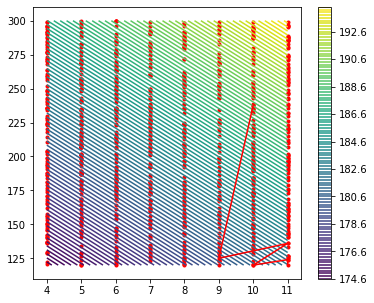

In [218]:
## blocks, Average delay time, time between consecutive train, maximum number of train that cn be run between 7 am to 10 pm
random.seed(41)
monte_carlo(1000)

(6, 11, 122, 480, 190)

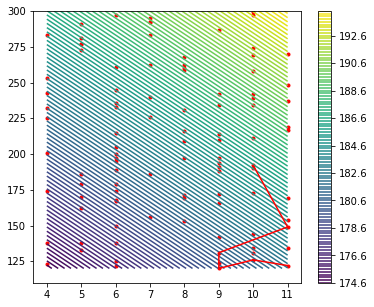

In [211]:
random.seed(130)
monte_carlo(100)

(5, 11, 122, 549, 191)

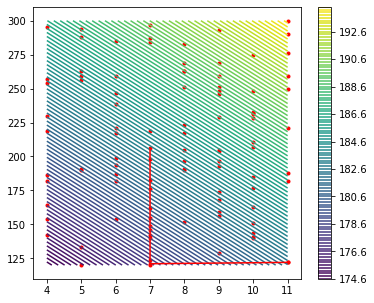

In [213]:
random.seed(120)
monte_carlo(100)

In [147]:
df.head()

,Number_of_Blocks,Number_of_trains,Average_delay_time,time_between_consecutive_trains
0,9,90,300,600
1,4,180,120,300
2,5,105,230,480
3,6,90,280,600
4,7,120,240,480


Using Linear Programming

In [209]:
from scipy.optimize import linprog
obj = [-231.1701,-1.7341, 0.5916, -0.0251]
#obj = [-222.3718, -3.1466, 0.6799, -0.0665]
lhs_ineq = [[0,0,1,1]]
rhs_ineq = [0.5]
bnd = [(1,1),
       (4, 11),
       (120,300),
       (300,600)]
opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,bounds = bnd, method="revised simplex")

In [210]:
opt

     con: array([], dtype=float64)
     fun: -186.78319999999997
 message: 'The problem appears infeasible, as the phase one auxiliary problem terminated successfully with a residual of 4.2e+02, greater than the tolerance 1e-12 required for the solution to be considered feasible. Consider increasing the tolerance to be greater than 4.2e+02. If this tolerance is unnaceptably large, the problem is likely infeasible.'
     nit: 0
   slack: array([-419.5])
  status: 2
 success: False
       x: array([  1.,  11., 120., 300.])